# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 4202496/11490434 [=========>....................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 13:33 - loss: 0.6957

  36/1875 [..............................] - ETA: 2s - loss: 0.5266   

  67/1875 [>.............................] - ETA: 2s - loss: 0.4549

 102/1875 [>.............................] - ETA: 2s - loss: 0.4117

 140/1875 [=>............................] - ETA: 2s - loss: 0.3826

 176/1875 [=>............................] - ETA: 2s - loss: 0.3629

 213/1875 [==>...........................] - ETA: 2s - loss: 0.3472

 249/1875 [==>...........................] - ETA: 2s - loss: 0.3347

 283/1875 [===>..........................] - ETA: 2s - loss: 0.3248

 313/1875 [====>.........................] - ETA: 2s - loss: 0.3171

 348/1875 [====>.........................] - ETA: 2s - loss: 0.3091

 388/1875 [=====>........................] - ETA: 2s - loss: 0.3011

 419/1875 [=====>........................] - ETA: 2s - loss: 0.2955

 451/1875 [======>.......................] - ETA: 2s - loss: 0.2902

 482/1875 [======>.......................] - ETA: 2s - loss: 0.2854

 519/1875 [=======>......................] - ETA: 1s - loss: 0.2803

 551/1875 [=======>......................] - ETA: 1s - loss: 0.2761

 584/1875 [========>.....................] - ETA: 1s - loss: 0.2721

 619/1875 [========>.....................] - ETA: 1s - loss: 0.2682

 653/1875 [=========>....................] - ETA: 1s - loss: 0.2646

 681/1875 [=========>....................] - ETA: 1s - loss: 0.2618

 711/1875 [==========>...................] - ETA: 1s - loss: 0.2589

 740/1875 [==========>...................] - ETA: 1s - loss: 0.2563

 776/1875 [===========>..................] - ETA: 1s - loss: 0.2533

 814/1875 [============>.................] - ETA: 1s - loss: 0.2502

 853/1875 [============>.................] - ETA: 1s - loss: 0.2472

 890/1875 [=============>................] - ETA: 1s - loss: 0.2446

 928/1875 [=============>................] - ETA: 1s - loss: 0.2420

 965/1875 [==============>...............] - ETA: 1s - loss: 0.2396

1003/1875 [===============>..............] - ETA: 1s - loss: 0.2372

1042/1875 [===============>..............] - ETA: 1s - loss: 0.2349

1075/1875 [================>.............] - ETA: 1s - loss: 0.2330

1108/1875 [================>.............] - ETA: 1s - loss: 0.2312

1141/1875 [=================>............] - ETA: 1s - loss: 0.2294

1177/1875 [=================>............] - ETA: 1s - loss: 0.2276

1211/1875 [==================>...........] - ETA: 0s - loss: 0.2259

1240/1875 [==================>...........] - ETA: 0s - loss: 0.2246

1276/1875 [===================>..........] - ETA: 0s - loss: 0.2229

1310/1875 [===================>..........] - ETA: 0s - loss: 0.2214

1343/1875 [====================>.........] - ETA: 0s - loss: 0.2200

1371/1875 [====================>.........] - ETA: 0s - loss: 0.2188

1405/1875 [=====================>........] - ETA: 0s - loss: 0.2174

1440/1875 [======================>.......] - ETA: 0s - loss: 0.2160

1471/1875 [======================>.......] - ETA: 0s - loss: 0.2148

1503/1875 [=======================>......] - ETA: 0s - loss: 0.2136

1533/1875 [=======================>......] - ETA: 0s - loss: 0.2125

1567/1875 [========================>.....] - ETA: 0s - loss: 0.2113

1595/1875 [========================>.....] - ETA: 0s - loss: 0.2103

1628/1875 [=========================>....] - ETA: 0s - loss: 0.2092

1667/1875 [=========================>....] - ETA: 0s - loss: 0.2079

1705/1875 [==========================>...] - ETA: 0s - loss: 0.2067

1744/1875 [==========================>...] - ETA: 0s - loss: 0.2055

1782/1875 [===========================>..] - ETA: 0s - loss: 0.2043

1821/1875 [============================>.] - ETA: 0s - loss: 0.2032

1860/1875 [============================>.] - ETA: 0s - loss: 0.2021

1875/1875 [==============================] - 3s 1ms/step - loss: 0.2016


Epoch 2/5
   1/1875 [..............................] - ETA: 2s - loss: 0.1034

  39/1875 [..............................] - ETA: 2s - loss: 0.1083

  78/1875 [>.............................] - ETA: 2s - loss: 0.1082

 117/1875 [>.............................] - ETA: 2s - loss: 0.1082

 157/1875 [=>............................] - ETA: 2s - loss: 0.1082

 196/1875 [==>...........................] - ETA: 2s - loss: 0.1082

 234/1875 [==>...........................] - ETA: 2s - loss: 0.1082

 265/1875 [===>..........................] - ETA: 2s - loss: 0.1081

 304/1875 [===>..........................] - ETA: 2s - loss: 0.1080

 342/1875 [====>.........................] - ETA: 2s - loss: 0.1080

 381/1875 [=====>........................] - ETA: 1s - loss: 0.1079

 419/1875 [=====>........................] - ETA: 1s - loss: 0.1078

 458/1875 [======>.......................] - ETA: 1s - loss: 0.1078

 497/1875 [======>.......................] - ETA: 1s - loss: 0.1077

 536/1875 [=======>......................] - ETA: 1s - loss: 0.1077

 575/1875 [========>.....................] - ETA: 1s - loss: 0.1076

 614/1875 [========>.....................] - ETA: 1s - loss: 0.1075

 653/1875 [=========>....................] - ETA: 1s - loss: 0.1075

 681/1875 [=========>....................] - ETA: 1s - loss: 0.1074

 719/1875 [==========>...................] - ETA: 1s - loss: 0.1074

 758/1875 [===========>..................] - ETA: 1s - loss: 0.1073

 794/1875 [===========>..................] - ETA: 1s - loss: 0.1072

 832/1875 [============>.................] - ETA: 1s - loss: 0.1071

 870/1875 [============>.................] - ETA: 1s - loss: 0.1071

 907/1875 [=============>................] - ETA: 1s - loss: 0.1070

 944/1875 [==============>...............] - ETA: 1s - loss: 0.1069

 982/1875 [==============>...............] - ETA: 1s - loss: 0.1069



1020/1875 [===============>..............] - ETA: 1s - loss: 0.1068

1058/1875 [===============>..............] - ETA: 1s - loss: 0.1067

1096/1875 [================>.............] - ETA: 1s - loss: 0.1067

1134/1875 [=================>............] - ETA: 0s - loss: 0.1066

1171/1875 [=================>............] - ETA: 0s - loss: 0.1065

1208/1875 [==================>...........] - ETA: 0s - loss: 0.1065

1246/1875 [==================>...........] - ETA: 0s - loss: 0.1064

1284/1875 [===================>..........] - ETA: 0s - loss: 0.1063

1323/1875 [====================>.........] - ETA: 0s - loss: 0.1063

1362/1875 [====================>.........] - ETA: 0s - loss: 0.1062

1401/1875 [=====================>........] - ETA: 0s - loss: 0.1061

1441/1875 [======================>.......] - ETA: 0s - loss: 0.1061

1481/1875 [======================>.......] - ETA: 0s - loss: 0.1060

1520/1875 [=======================>......] - ETA: 0s - loss: 0.1060

1559/1875 [=======================>......] - ETA: 0s - loss: 0.1059

1598/1875 [========================>.....] - ETA: 0s - loss: 0.1058

1636/1875 [=========================>....] - ETA: 0s - loss: 0.1058

1673/1875 [=========================>....] - ETA: 0s - loss: 0.1057

1711/1875 [==========================>...] - ETA: 0s - loss: 0.1057

1749/1875 [==========================>...] - ETA: 0s - loss: 0.1056

1788/1875 [===========================>..] - ETA: 0s - loss: 0.1055

1827/1875 [============================>.] - ETA: 0s - loss: 0.1055

1865/1875 [============================>.] - ETA: 0s - loss: 0.1054

1875/1875 [==============================] - 2s 1ms/step - loss: 0.1054


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0988

  40/1875 [..............................] - ETA: 2s - loss: 0.0985

  79/1875 [>.............................] - ETA: 2s - loss: 0.0988

 118/1875 [>.............................] - ETA: 2s - loss: 0.0988

 157/1875 [=>............................] - ETA: 2s - loss: 0.0987

 195/1875 [==>...........................] - ETA: 2s - loss: 0.0986

 233/1875 [==>...........................] - ETA: 2s - loss: 0.0986

 272/1875 [===>..........................] - ETA: 2s - loss: 0.0986

 310/1875 [===>..........................] - ETA: 2s - loss: 0.0985

 343/1875 [====>.........................] - ETA: 2s - loss: 0.0985

 381/1875 [=====>........................] - ETA: 1s - loss: 0.0984

 420/1875 [=====>........................] - ETA: 1s - loss: 0.0984

 458/1875 [======>.......................] - ETA: 1s - loss: 0.0983

 496/1875 [======>.......................] - ETA: 1s - loss: 0.0983

 533/1875 [=======>......................] - ETA: 1s - loss: 0.0983

 571/1875 [========>.....................] - ETA: 1s - loss: 0.0983

 609/1875 [========>.....................] - ETA: 1s - loss: 0.0982

 647/1875 [=========>....................] - ETA: 1s - loss: 0.0982

 685/1875 [=========>....................] - ETA: 1s - loss: 0.0982

 723/1875 [==========>...................] - ETA: 1s - loss: 0.0981

 761/1875 [===========>..................] - ETA: 1s - loss: 0.0981

 799/1875 [===========>..................] - ETA: 1s - loss: 0.0981

 836/1875 [============>.................] - ETA: 1s - loss: 0.0981

 873/1875 [============>.................] - ETA: 1s - loss: 0.0981

 910/1875 [=============>................] - ETA: 1s - loss: 0.0980

 949/1875 [==============>...............] - ETA: 1s - loss: 0.0980

 980/1875 [==============>...............] - ETA: 1s - loss: 0.0980

1016/1875 [===============>..............] - ETA: 1s - loss: 0.0980

1051/1875 [===============>..............] - ETA: 1s - loss: 0.0980

1084/1875 [================>.............] - ETA: 1s - loss: 0.0979

1124/1875 [================>.............] - ETA: 1s - loss: 0.0979

1162/1875 [=================>............] - ETA: 0s - loss: 0.0979

1201/1875 [==================>...........] - ETA: 0s - loss: 0.0979

1240/1875 [==================>...........] - ETA: 0s - loss: 0.0979

1279/1875 [===================>..........] - ETA: 0s - loss: 0.0979

1310/1875 [===================>..........] - ETA: 0s - loss: 0.0979

1348/1875 [====================>.........] - ETA: 0s - loss: 0.0978

1388/1875 [=====================>........] - ETA: 0s - loss: 0.0978

1427/1875 [=====================>........] - ETA: 0s - loss: 0.0978

1466/1875 [======================>.......] - ETA: 0s - loss: 0.0978

1492/1875 [======================>.......] - ETA: 0s - loss: 0.0978

1527/1875 [=======================>......] - ETA: 0s - loss: 0.0978

1563/1875 [========================>.....] - ETA: 0s - loss: 0.0978

1600/1875 [========================>.....] - ETA: 0s - loss: 0.0978

1634/1875 [=========================>....] - ETA: 0s - loss: 0.0977

1665/1875 [=========================>....] - ETA: 0s - loss: 0.0977

1703/1875 [==========================>...] - ETA: 0s - loss: 0.0977

1737/1875 [==========================>...] - ETA: 0s - loss: 0.0977

1776/1875 [===========================>..] - ETA: 0s - loss: 0.0977

1813/1875 [============================>.] - ETA: 0s - loss: 0.0977

1852/1875 [============================>.] - ETA: 0s - loss: 0.0977

1875/1875 [==============================] - 3s 1ms/step - loss: 0.0977


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0946

  37/1875 [..............................] - ETA: 2s - loss: 0.0947

  75/1875 [>.............................] - ETA: 2s - loss: 0.0951

 114/1875 [>.............................] - ETA: 2s - loss: 0.0953

 153/1875 [=>............................] - ETA: 2s - loss: 0.0955

 191/1875 [==>...........................] - ETA: 2s - loss: 0.0956

 230/1875 [==>...........................] - ETA: 2s - loss: 0.0957

 268/1875 [===>..........................] - ETA: 2s - loss: 0.0957

 307/1875 [===>..........................] - ETA: 2s - loss: 0.0958

 346/1875 [====>.........................] - ETA: 2s - loss: 0.0958

 384/1875 [=====>........................] - ETA: 1s - loss: 0.0958

 423/1875 [=====>........................] - ETA: 1s - loss: 0.0958

 462/1875 [======>.......................] - ETA: 1s - loss: 0.0958

 501/1875 [=======>......................] - ETA: 1s - loss: 0.0958

 540/1875 [=======>......................] - ETA: 1s - loss: 0.0959

 579/1875 [========>.....................] - ETA: 1s - loss: 0.0959

 618/1875 [========>.....................] - ETA: 1s - loss: 0.0959

 657/1875 [=========>....................] - ETA: 1s - loss: 0.0959

 696/1875 [==========>...................] - ETA: 1s - loss: 0.0959

 735/1875 [==========>...................] - ETA: 1s - loss: 0.0959

 774/1875 [===========>..................] - ETA: 1s - loss: 0.0959

 812/1875 [===========>..................] - ETA: 1s - loss: 0.0959

 850/1875 [============>.................] - ETA: 1s - loss: 0.0959

 889/1875 [=============>................] - ETA: 1s - loss: 0.0959

 928/1875 [=============>................] - ETA: 1s - loss: 0.0959

 967/1875 [==============>...............] - ETA: 1s - loss: 0.0959

1006/1875 [===============>..............] - ETA: 1s - loss: 0.0959

1044/1875 [===============>..............] - ETA: 1s - loss: 0.0959

1083/1875 [================>.............] - ETA: 1s - loss: 0.0959

1122/1875 [================>.............] - ETA: 0s - loss: 0.0959

1161/1875 [=================>............] - ETA: 0s - loss: 0.0959

1199/1875 [==================>...........] - ETA: 0s - loss: 0.0959

1237/1875 [==================>...........] - ETA: 0s - loss: 0.0959

1276/1875 [===================>..........] - ETA: 0s - loss: 0.0959

1315/1875 [====================>.........] - ETA: 0s - loss: 0.0959

1354/1875 [====================>.........] - ETA: 0s - loss: 0.0960

1392/1875 [=====================>........] - ETA: 0s - loss: 0.0960

1430/1875 [=====================>........] - ETA: 0s - loss: 0.0960

1469/1875 [======================>.......] - ETA: 0s - loss: 0.0959

1508/1875 [=======================>......] - ETA: 0s - loss: 0.0959

1547/1875 [=======================>......] - ETA: 0s - loss: 0.0959

1586/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1625/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1664/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1703/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1741/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1780/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1818/1875 [============================>.] - ETA: 0s - loss: 0.0959

1857/1875 [============================>.] - ETA: 0s - loss: 0.0959

1875/1875 [==============================] - 2s 1ms/step - loss: 0.0959


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1010

  40/1875 [..............................] - ETA: 2s - loss: 0.0962

  79/1875 [>.............................] - ETA: 2s - loss: 0.0957

 118/1875 [>.............................] - ETA: 2s - loss: 0.0955

 157/1875 [=>............................] - ETA: 2s - loss: 0.0954

 195/1875 [==>...........................] - ETA: 2s - loss: 0.0952

 233/1875 [==>...........................] - ETA: 2s - loss: 0.0951

 271/1875 [===>..........................] - ETA: 2s - loss: 0.0951

 308/1875 [===>..........................] - ETA: 2s - loss: 0.0950

 344/1875 [====>.........................] - ETA: 2s - loss: 0.0950

 382/1875 [=====>........................] - ETA: 1s - loss: 0.0950

 421/1875 [=====>........................] - ETA: 1s - loss: 0.0949

 459/1875 [======>.......................] - ETA: 1s - loss: 0.0950

 497/1875 [======>.......................] - ETA: 1s - loss: 0.0950

 536/1875 [=======>......................] - ETA: 1s - loss: 0.0950

 574/1875 [========>.....................] - ETA: 1s - loss: 0.0950

 613/1875 [========>.....................] - ETA: 1s - loss: 0.0950

 652/1875 [=========>....................] - ETA: 1s - loss: 0.0950

 691/1875 [==========>...................] - ETA: 1s - loss: 0.0950

 730/1875 [==========>...................] - ETA: 1s - loss: 0.0950

 769/1875 [===========>..................] - ETA: 1s - loss: 0.0950

 807/1875 [===========>..................] - ETA: 1s - loss: 0.0950

 845/1875 [============>.................] - ETA: 1s - loss: 0.0950

 884/1875 [=============>................] - ETA: 1s - loss: 0.0950

 922/1875 [=============>................] - ETA: 1s - loss: 0.0950

 961/1875 [==============>...............] - ETA: 1s - loss: 0.0950

1000/1875 [===============>..............] - ETA: 1s - loss: 0.0950

1039/1875 [===============>..............] - ETA: 1s - loss: 0.0951

1078/1875 [================>.............] - ETA: 1s - loss: 0.0951

1117/1875 [================>.............] - ETA: 0s - loss: 0.0951

1156/1875 [=================>............] - ETA: 0s - loss: 0.0951

1195/1875 [==================>...........] - ETA: 0s - loss: 0.0951

1234/1875 [==================>...........] - ETA: 0s - loss: 0.0951

1272/1875 [===================>..........] - ETA: 0s - loss: 0.0951

1311/1875 [===================>..........] - ETA: 0s - loss: 0.0951

1349/1875 [====================>.........] - ETA: 0s - loss: 0.0951

1387/1875 [=====================>........] - ETA: 0s - loss: 0.0951

1424/1875 [=====================>........] - ETA: 0s - loss: 0.0951

1462/1875 [======================>.......] - ETA: 0s - loss: 0.0951

1500/1875 [=======================>......] - ETA: 0s - loss: 0.0951

1539/1875 [=======================>......] - ETA: 0s - loss: 0.0951

1575/1875 [========================>.....] - ETA: 0s - loss: 0.0951

1613/1875 [========================>.....] - ETA: 0s - loss: 0.0951

1651/1875 [=========================>....] - ETA: 0s - loss: 0.0951

1688/1875 [==========================>...] - ETA: 0s - loss: 0.0951

1726/1875 [==========================>...] - ETA: 0s - loss: 0.0951

1763/1875 [===========================>..] - ETA: 0s - loss: 0.0951

1796/1875 [===========================>..] - ETA: 0s - loss: 0.0951

1828/1875 [============================>.] - ETA: 0s - loss: 0.0951

1861/1875 [============================>.] - ETA: 0s - loss: 0.0951

1875/1875 [==============================] - 3s 1ms/step - loss: 0.0951


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

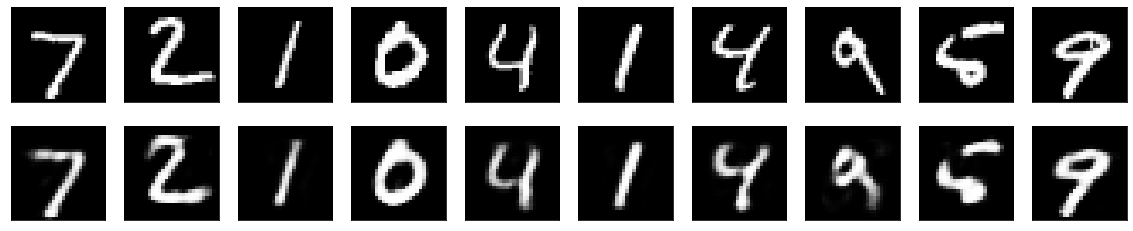

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
